In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import pickle
import enum
from tqdm import tqdm_notebook
import torchvision


## High-dimensional data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

mnist_path = '/content/drive/My Drive/Colab Notebooks/mnist-hw1.pkl'

with open(mnist_path, 'rb') as f:
    dataset = pickle.load(f)

train = dataset['train']
test = dataset['test']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


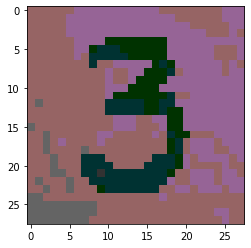

In [3]:
plt.imshow(train[50] * 50);

In [4]:
def swap_channels(data):
    return data.transpose(0, 3, 1, 2)

train = swap_channels(train)
test = swap_channels(test)
print(train.shape)

(60000, 3, 28, 28)


In [0]:
class Type(enum.Enum):
    A = 1
    B = 2

class MaskedCNN(torch.nn.Conv2d):
    def __init__(self, conv_type, *args, **kwargs):
        super().__init__(*args, **kwargs)    
        self.register_buffer('mask', torch.ones_like(self.weight))
        h, w = self.weight.shape[2:]
        self.mask[:, :, h // 2 + 1:] = 0
        self.mask[:, :, h // 2, w // 2:] = 0
        
        if conv_type == Type.B:
            self.mask[:, :, h // 2, w // 2] = 1
    
    def forward(self, X):
        self.weight.data *= self.mask
        return super(MaskedCNN, self).forward(X)
    
    
class ResidualBlock(torch.nn.Module):
    def __init__(self, h):
        super(ResidualBlock, self).__init__()
        
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(2 * h, h, 1),
            torch.nn.ReLU(),
            MaskedCNN(Type.B, h, h, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(h, 2 * h, 1),
            torch.nn.ReLU(),
        )
        
    def forward(self, X):
        return self.model(X) + X

    
class PixelCnn(torch.nn.Module):
    
    def __init__(self, h):
        super(PixelCnn, self).__init__()
        
        residuals = [ResidualBlock(h) for _ in range(12)]
        
        self.model = torch.nn.Sequential(
            MaskedCNN(Type.A, 3, h * 2, 7, stride=1, padding=3),
            *residuals,
            torch.nn.Conv2d(2 * h, 2 * h, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(2 * h, 3 * 4, 1)
        )
        
        self.softmax = torch.nn.Softmax(dim=4)
    
    def forward(self, X):
        x = X.float()
        n, c, h, w = x.shape
        out = self.model(x)
        out = out.reshape(n, c, 4, h, w)
        out = out.permute(0, 1, 3, 4, 2)
        
        out = self.softmax(out)
        X = X.long()
        probs = torch.gather(out, 4, X.view(n, c, h, w, 1))
        
        return probs, out
    
    def sample(self, N):
        x = torch.zeros((N, 3, 28, 28)).to(device)
        with torch.no_grad():
            for i in tqdm_notebook(range(28)):
                for j in range(28):
                    for k in range(3):
                        _, dist = self.forward(x)
                        for n in range(N):
                            x[n, k, i, j] = np.random.choice(4, p=dist[n, k, i, j].detach().cpu().numpy())
        return x

def get_loss(probs):
    return -torch.sum(torch.log2(probs))

In [0]:
batch_size = 128
num_epochs = 20
h = 128

train_batches = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_batches = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True) 
test = torch.tensor(test)

model = PixelCnn(h)
model.to(device)
path = "/content/drive/My Drive/Colab Notebooks/model.data"
model.load_state_dict(torch.load(path))
model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []

In [7]:
for epoch in range(num_epochs):
    loss = 0
    for batch in tqdm_notebook(train_batches):
        optimizer.zero_grad()
        batch = batch.to(device)
        outputs, _ = model(batch)
        cur_loss = get_loss(outputs)
        loss += cur_loss.item()
        cur_loss.backward()
        optimizer.step()
        
    train_losses.append(loss / len(train))
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm_notebook(test_batches):
            batch = batch.to(device)
            outputs, _ = model(batch)
            val_loss += get_loss(outputs).item()

    val_losses.append(val_loss / len(test))
    torch.save(model.state_dict(), path)
    
    print(f'Epoch {epoch}: training loss {loss / len(train)}, validation loss {val_losses[-1]}')


Epoch 0: training loss 968.3383279947917, validation loss 662.4426133789062



Epoch 1: training loss 784.0821236979167, validation loss 672.3424677734375



Epoch 2: training loss 809.1714920572916, validation loss 764.8771638671875



Epoch 3: training loss 680.1479372395834, validation loss 596.57278828125



Epoch 4: training loss 765.0669188802083, validation loss 808.3597169921875



Epoch 5: training loss 701.9492631510417, validation loss 624.3940037109375



Epoch 6: training loss 580.8276748697916, validation loss 525.5532911132813



Epoch 7: training loss 895.5224565755208, validation loss 809.8571279296875



Epoch 8: training loss 772.030997265625, validation loss 725.42218046875



Epoch 9: training loss 703.884563671875, validation loss 685.8877599609375



Epoch 10: training loss 650.4525765625, validation loss 616.2271010742187



Epoch 11: training loss 605.85612421875, validation loss 575.62747578125



Epoch 12: training loss 562.1344725911458, validation loss 540.1772015625



Epoch 13: training loss 534.4731533203125, validation loss 505.8675388671875



Epoch 14: training loss 721.5989069661458, validation loss 780.5510943359375



Epoch 15: training loss 691.4399365234375, validation loss 620.4777375



Epoch 16: training loss 587.7755784505208, validation loss 543.6053189453125



Epoch 17: training loss 546.2378447916667, validation loss 593.0555197265625



Epoch 18: training loss 479.97941953125, validation loss 453.00950732421876



Epoch 19: training loss 840.9420964192708, validation loss 719.9783765625


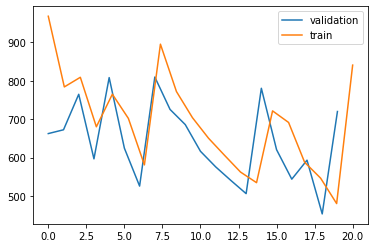

In [8]:
plt.plot(np.arange(len(val_losses)), val_losses)
plt.plot(np.linspace(0, len(val_losses), len(train_losses)), train_losses)
plt.legend(('validation','train'));

In [12]:
pics = model.sample(9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


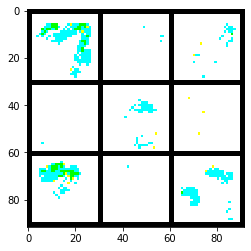

In [13]:
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

grid = torchvision.utils.make_grid(pics, nrow=3)
imshow(grid)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


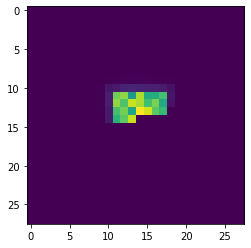

In [14]:
def receptive_field():
    optimizer.zero_grad()
    cnn = PixelCnn(h)
    x = torch.tensor(test[:batch_size].float(), requires_grad=True)
    out, _ = cnn(x)
    
    loss = get_loss(out[:, 0, 14, 14])
    loss.backward()
    grad = torch.sum(x.grad.abs(), dim=(0, 1))
    plt.imshow(grad)
    
receptive_field()